# README
This notebook is used to split the dataset.

In [1]:
import numpy as np
import pickle
import pandas as pd
import numpy as np
import random
import os
from batteryml.data.battery_data import BatteryData
import matplotlib.pyplot as plt
import json
random.seed(2024)
np.random.seed(2024)

# StandfordU dataset

In [5]:
# Here is the train_ids provided by BatteryML
data_path = '../dataset/Stanford'
tmp_files = os.listdir(data_path)
life_labels = json.load(open('../dataset/Stanford_labels.json'))
files = [i for i in tmp_files if i in life_labels]

test_ratio = 0.2
testing_set = random.sample(files, int(len(files)*0.2))
training_set = [i for i in files if i not in testing_set]

val_ratio = 0.2

validation_set= random.sample(training_set, int(len(training_set)*0.25))
training_set = [i for i in training_set if i not in validation_set]


assert len(training_set) + len(validation_set) + len(testing_set) == len(files)

print(f'training_set: {len(training_set)} {training_set}')
print(f'Val set: {len(validation_set)} {validation_set}')
print(f'Test set: {len(testing_set)} {testing_set}')

training_set: 25 ['Stanford_Nova_Regular_228.pkl', 'Stanford_Nova_Regular_203.pkl', 'Stanford_Nova_Regular_215.pkl', 'Stanford_Nova_Regular_225.pkl', 'Stanford_Nova_Regular_222.pkl', 'Stanford_Nova_Regular_226.pkl', 'Stanford_Nova_Regular_221.pkl', 'Stanford_Nova_Regular_211.pkl', 'Stanford_Nova_Regular_219.pkl', 'Stanford_Nova_Regular_229.pkl', 'Stanford_Nova_Regular_193.pkl', 'Stanford_Nova_Regular_200.pkl', 'Stanford_Nova_Regular_205.pkl', 'Stanford_Nova_Regular_230.pkl', 'Stanford_Nova_Regular_196.pkl', 'Stanford_Nova_Regular_216.pkl', 'Stanford_Nova_Regular_220.pkl', 'Stanford_Nova_Regular_201.pkl', 'Stanford_Nova_Regular_Ref_101.pkl', 'Stanford_Nova_Regular_192.pkl', 'Stanford_Nova_Regular_208.pkl', 'Stanford_Nova_Regular_Ref_102.pkl', 'Stanford_Nova_Regular_210.pkl', 'Stanford_Nova_Regular_212.pkl', 'Stanford_Nova_Regular_199.pkl']
Val set: 8 ['Stanford_Nova_Regular_217.pkl', 'Stanford_Nova_Regular_194.pkl', 'Stanford_Nova_Regular_214.pkl', 'Stanford_Nova_Regular_195.pkl', 'Stan

# Data check

In [2]:
def resample_charge_discharge_curves(voltages, currents, capacity_in_battery):
    '''
    resample the charge and discharge curves
    :param voltages:charge or dicharge voltages
    :param currents: charge or discharge current
    :param capacity_in_battery: remaining capacities in the battery
    :return:interploted records
    '''
    charge_discharge_len = 300 // 2
    raw_bases = np.arange(1, len(voltages)+1)
    interp_bases = np.linspace(1, len(voltages)+1, num=charge_discharge_len,
                                    endpoint=True)
    interp_voltages = np.interp(interp_bases, raw_bases, voltages)
    interp_currents = np.interp(interp_bases, raw_bases, currents)
    interp_capacity_in_battery = np.interp(interp_bases, raw_bases, capacity_in_battery)
    return interp_voltages, interp_currents, interp_capacity_in_battery

999


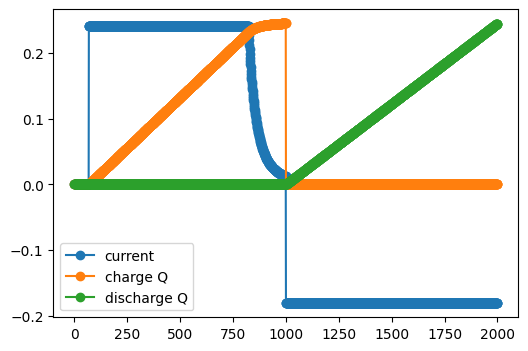

In [6]:
data = pickle.load(open('/data/trf/python_works/Battery-LLM/dataset/Stanford/Stanford_Nova_Regular_192.pkl', 'rb'))
#data = pickle.load(open('../dataset/HUST/HUST_7-5.pkl', 'rb'))
cycle_data = data['cycle_data']
nominal_capacity = data['nominal_capacity_in_Ah']
need_keys = ['current_in_A', 'voltage_in_V', 'charge_capacity_in_Ah', 'discharge_capacity_in_Ah', 'time_in_s']
fig = plt.figure(figsize=(6,4))
for correct_cycle_index, sub_cycle_data in enumerate(cycle_data[0:1]):
    cycle_df = pd.DataFrame()
    for key in need_keys:
        cycle_df[key] = sub_cycle_data[key]    
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df['cycle_number'] = correct_cycle_index + 1
    cycle_df.loc[cycle_df['charge_capacity_in_Ah']<0] = np.nan
    cycle_df.bfill(inplace=True) # deal with NaN
    voltage_records = cycle_df['voltage_in_V'].values
    current_records = cycle_df['current_in_A'].values
    current_records_in_C = current_records/nominal_capacity
    charge_capacity_records = cycle_df['charge_capacity_in_Ah'].values
    discharge_capacity_records = cycle_df['discharge_capacity_in_Ah'].values

    cutoff_voltage_indices = np.nonzero(current_records_in_C>=0.01) # This includes constant-voltage charge data, 49th cycle of MATR_b1c18 has some abnormal voltage records
    charge_end_index = cutoff_voltage_indices[0][-1] # after charge_end_index, there are rest after charge, discharge, and rest after discharge data
    print(charge_end_index)

    discharge_voltages = voltage_records[charge_end_index:]
    discharge_capacities = discharge_capacity_records[charge_end_index:]
    discharge_currents = current_records[charge_end_index:]
    discharge_current_in_C = discharge_currents / nominal_capacity
    
    discharge_voltages = discharge_voltages[np.abs(discharge_current_in_C)>0.01]
    discharge_capacities = discharge_capacities[np.abs(discharge_current_in_C)>0.01]
    discharge_currents = discharge_currents[np.abs(discharge_current_in_C)>0.01]
    
    charge_voltages = voltage_records[:charge_end_index]
    charge_capacities = charge_capacity_records[:charge_end_index]
    charge_currents = current_records[:charge_end_index]

    discharge_voltages, discharge_currents, discharge_capacities = resample_charge_discharge_curves(discharge_voltages, discharge_currents, discharge_capacities)
    #plt.plot(discharge_capacities, discharge_voltages, marker='o')
    plt.plot(current_records, marker='o', label='current')
    plt.plot(cycle_df['charge_capacity_in_Ah'].values, marker='o', label='charge Q')
    plt.plot(cycle_df['discharge_capacity_in_Ah'].values, marker='o', label='discharge Q')
plt.legend()
plt.show()